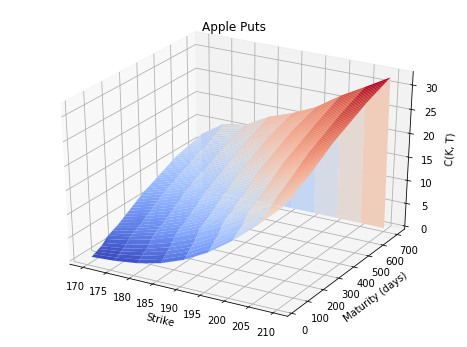

In [2]:
import warnings
warnings.filterwarnings("ignore")
import modulesForCalibration as mfc
import matplotlib.pyplot as plt

#import readPlotOptionSurface_granular_k2_5 as marketSurface
import readPlotPutSurfaceedited as marketSurface
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin


import plotly.plotly as py
import plotly.graph_objs as go

# This report reflects the work of Lisa He, Alban Zapke, and Naijia Yao, for the project of volatility surface in Computational Methods in Finance with Prof. Hirsa.

## APPL

###  We set up Grid for Model Prices as provided in readPlotOptionSurface.py provided by Prof. Hirsa

### deltaK = 5 & deltaTau = 1/52

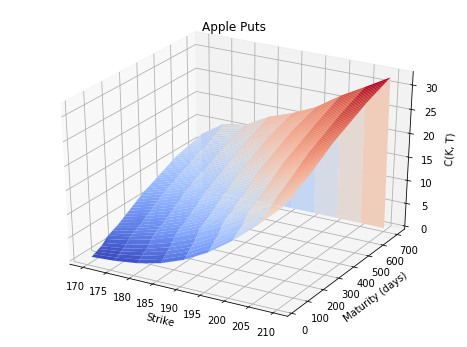

In [3]:
maturities, strikes, marketPrices = marketSurface.readNPlot()

In [4]:
maturities_years = maturities/365

# I. Model Prices

### Global Parameters

In [5]:
# Contract Parameters
S0 = 190
K = 190
k = np.log(K)
# risk free rate
r = 0.0245
# dividend rate
q = 0.005

# Parameters
alpha = -1.5                       # Why?
eta = 0.2

n = 12
N = 2**n

# step-size in log strike space  --> FFT constraint
#lda = (2*np.pi/N)/eta

# Choice of beta
#beta = np.log(S0)-N*lda/2
# beta = np.log(K)

* Grid for Model Prices was set up in readPlotOptionSurface

## 1. Finding a starting point; code provided as in exampleCalibration_FindingStartingPoint.py by Prof. Hirsa

In [6]:
iArray = []                             # The alphas (0,1) which are plotted agains RMSE -> calling it i instead here
rmseArray = []
rmseMin = 1e10                          # Random; in order to have an error to start with

### Model specific parameters:

#### Heston 

In [7]:
model = 'VGSSD'

#set 1: promising starting point
params1 = (1.0, 0.02, 0.05, 0.4)
params2 = (3.0, 0.06, 0.10, 0.6)

In [8]:
lenT = len(maturities_years)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

In [9]:
modelPrices.shape == marketPrices.shape

True

In [10]:
marketPrices.shape


(98, 9)

In [11]:
iArray = []
rmseArray=[]
for i in mfc.myRange(0.0, 1.0, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

In [12]:
len(rmseArray) == len(iArray)
print(len(rmseArray))
print(len(iArray))
#print(rmseArray)
#print(iArray)

20
20


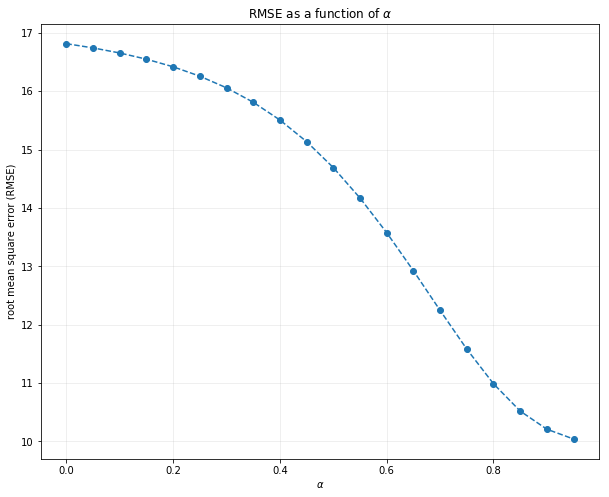

10.040346334500155
[1.1    0.022  0.0525 0.41  ]


In [13]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.savefig('startingPoint4.png')
plt.show()

print(rmseMin)
print(optimParams)

In [14]:
# Starting point Parameters 
sigma  = 1.1 
nu     = 0.022
theta  = 0.0525
gamma  = 0.41

## 2. Optimization of Parameter Set

#### - Objective Function -

In [14]:
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [15]:
lenT = len(maturities)
lenK = len(strikes)

#### A) Brute Force Algorithm 

In [16]:
# maturities, strikes, marketPrices = marketSurface.readNPlot()

#==========================================
# Grid Search around the starting point
#------------------------------------------
# [1.1    0.022  0.0525 0.41  ]
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(0.6,1.6,0.5):
    for theta in mfc.myRange(0.012,0.032,0.01):
        for sig in mfc.myRange(0.0425,0.0625,0.01):
            for rho in mfc.myRange(0.31,0.51,0.1):
                
                params = []
                params.append(kappa)
                params.append(theta)
                params.append(sig)
                params.append(rho)
                
                    
                print('i = ' + str(ind_iter))
                ind_iter += 1
                print(params)
                rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
                    
                if (rmse < rmseMin):
                    rmseMin = rmse
                    params2 = params
                    print('\nnew min found')
                    print(rmseMin)
                    print(params2)
                    print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

i = 1
[0.6, 0.012, 0.0425, 0.31]

new min found
7.632240170284669
[0.6, 0.012, 0.0425, 0.31]

i = 2
[0.6, 0.012, 0.0425, 0.41000000000000003]

new min found
7.121264928205782
[0.6, 0.012, 0.0425, 0.41000000000000003]

i = 3
[0.6, 0.012, 0.0425, 0.51]

new min found
6.670124771856067
[0.6, 0.012, 0.0425, 0.51]

i = 4
[0.6, 0.012, 0.052500000000000005, 0.31]
i = 5
[0.6, 0.012, 0.052500000000000005, 0.41000000000000003]

new min found
6.631315878872822
[0.6, 0.012, 0.052500000000000005, 0.41000000000000003]

i = 6
[0.6, 0.012, 0.052500000000000005, 0.51]

new min found
6.186395435185238
[0.6, 0.012, 0.052500000000000005, 0.51]

i = 7
[0.6, 0.012, 0.0625, 0.31]
i = 8
[0.6, 0.012, 0.0625, 0.41000000000000003]

new min found
6.1815789635002405
[0.6, 0.012, 0.0625, 0.41000000000000003]

i = 9
[0.6, 0.012, 0.0625, 0.51]

new min found
5.745040496673993
[0.6, 0.012, 0.0625, 0.51]

i = 10
[0.6, 0.022, 0.0425, 0.31]
i = 11
[0.6, 0.022, 0.0425, 0.41000000000000003]
i = 12
[0.6, 0.022, 0.0425, 0.51

In [ ]:
# Solution of grid search:
# [0.6, 0.032, 0.0625, 0.51]


#### B) Nelder Mead Algorithm  (Gradient-free) from exampleCalibration_NelderMead.py

In [18]:
#==========================================
# Nelder-Mead Simplex Algorithm -- fmin
#==========================================
# [1.1    0.022  0.0525 0.41  ]

params = [1.1 ,   0.022 , 0.0525, 0.41  ]

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=200,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [0.99       0.022825   0.05446875 0.425375  ]
f_i = 9.659845159688247
i = 2
x_i = [0.99       0.022825   0.05446875 0.425375  ]
f_i = 9.659845159688247
i = 3
x_i = [0.97625    0.02114062 0.05766797 0.45035938]
f_i = 9.41739455568567
i = 4
x_i = [0.8834375  0.02269609 0.06154395 0.42425391]
f_i = 8.994506001626526
i = 5
x_i = [0.72101562 0.02321816 0.06110815 0.47594434]
f_i = 7.495096057227489
i = 6
x_i = [0.72101562 0.02321816 0.06110815 0.47594434]
f_i = 7.495096057227489
i = 7
x_i = [0.51079102 0.02112424 0.0732507  0.50718982]
f_i = 3.9605627344283336
i = 8
x_i = [0.45154785 0.02336735 0.0715822  0.48334906]
f_i = 3.373688956484217
i = 9
x_i = [0.45154785 0.02336735 0.0715822  0.48334906]
f_i = 3.373688956484217
i = 10
x_i = [0.45154785 0.02336735 0.0715822  0.48334906]
f_i = 3.373688956484217
i = 11
x_i = [0.45154785 0.02336735 0.0715822  0.48334906]
f_i = 3.373688956484217
i = 12
x_i = [0.45154785 0.02336735 0.0715822  0.48334906]
f_i = 3.373688956484217
i = 13
x_i = 

f_i = 2.2389625932574586
i = 99
x_i = [ 0.24927624  0.01974641 -0.01713533  0.64335462]
f_i = 2.2389625932574586
i = 100
x_i = [ 0.24927624  0.01974641 -0.01713533  0.64335462]
f_i = 2.2389625932574586
i = 101
x_i = [ 0.25053881  0.01977864 -0.01622874  0.64073762]
f_i = 2.238465290982221
i = 102
x_i = [ 0.25053881  0.01977864 -0.01622874  0.64073762]
f_i = 2.238465290982221
i = 103
x_i = [ 0.25053881  0.01977864 -0.01622874  0.64073762]
f_i = 2.238465290982221
i = 104
x_i = [ 0.25053881  0.01977864 -0.01622874  0.64073762]
f_i = 2.238465290982221
i = 105
x_i = [ 0.25053881  0.01977864 -0.01622874  0.64073762]
f_i = 2.238465290982221
i = 106
x_i = [ 0.25053881  0.01977864 -0.01622874  0.64073762]
f_i = 2.238465290982221
i = 107
x_i = [ 0.25281434  0.01958719 -0.01525894  0.64546668]
f_i = 2.238407343926554
i = 108
x_i = [ 0.25277953  0.01964444 -0.01513867  0.64419929]
f_i = 2.23835020281619
i = 109
x_i = [ 0.25277953  0.01964444 -0.01513867  0.64419929]
f_i = 2.23835020281619
i = 110


In [ ]:
#optimal params is 
#[ 0.25206038  0.01966621 -0.01549389  0.64362014]


#### C) BFGS Algorithm (Gradient-based) from exampleCalibration_BFGS.py

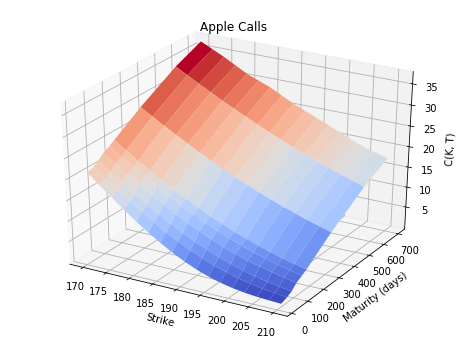

 
i = 1
x_i = [1.07971707 0.05105286 0.30470541 0.43132584]
f_i = 8.30279611274461
         Current function value: 8.302796
         Iterations: 1
         Function evaluations: 68
         Gradient evaluations: 10
optimal params = 
[1.07971707 0.05105286 0.30470541 0.43132584]
f = 8.30279611274461


In [19]:
import warnings
warnings.filterwarnings("ignore")

import readPlotOptionSurface 
import modulesForCalibration as mfc

from scipy.optimize import fmin_bfgs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

params = [1.1  ,  0.022 , 0.0525 ,0.41  ]

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

print('optimal params = ')
print(xopt)
print('f = ' + str(fopt))


In [ ]:
#optimal params = 
#[1.07971707 0.05105286 0.30470541 0.43132584]


### Evaluate which Optimization yields best results: Loss Function

In [20]:
# set 1: Brute-Force vs. Nelder-Mead
params_BF = [0.6, 0.032, 0.0625, 0.51]
params_NM = [ 0.25206038 , 0.01966621, -0.01549389,  0.64362014]

In [21]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.1):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_NM)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 0.07809057  0.01349931 -0.05449084  0.71043021]

-0.4
[ 0.11288453  0.01473269 -0.04669145  0.6970682 ]

-0.30000000000000004
[ 0.14767849  0.01596607 -0.03889206  0.68370618]

-0.20000000000000004
[ 0.18247246  0.01719945 -0.03109267  0.67034417]

-0.10000000000000003
[ 0.21726642  0.01843283 -0.02329328  0.65698215]

-2.7755575615628914e-17
[ 0.25206038  0.01966621 -0.01549389  0.64362014]

0.09999999999999998
[ 0.28685434  0.02089959 -0.0076945   0.63025813]

0.19999999999999998
[3.21648304e-01 2.21329680e-02 1.04888000e-04 6.16896112e-01]

0.3
[0.35644227 0.02336635 0.00790428 0.6035341 ]

0.4
[0.39123623 0.02459973 0.01570367 0.59017208]

0.5
[0.42603019 0.02583311 0.02350306 0.57681007]

0.6
[0.46082415 0.02706648 0.03130244 0.56344806]

0.7
[0.49561811 0.02829986 0.03910183 0.55008604]

0.7999999999999999
[0.53041208 0.02953324 0.04690122 0.53672403]

0.8999999999999999
[0.56520604 0.03076662 0.05470061 0.52336201]

0.9999999999999999
[0.6    0.032  0.0625 0.51  ]

1.099

In [ ]:
#optimal results are:

#[ 0.25206038  0.01966621 -0.01549389  0.64362014]
#NM is better

***Concludes that NM Parameters yield better result ***

In [22]:
# set 2: Brute-Force vs. BFGS
params_BF = [0.6, 0.032, 0.0625, 0.51]
params_BFGS = [1.07971707, 0.05105286, 0.30470541 ,0.43132584]

In [23]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.1):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[1.31957561 0.06057929 0.42580812 0.39198876]

-0.4
[1.2716039  0.058674   0.40158757 0.39985618]

-0.30000000000000004
[1.22363219 0.05676872 0.37736703 0.40772359]

-0.20000000000000004
[1.17566048 0.05486343 0.35314649 0.41559101]

-0.10000000000000003
[1.12768878 0.05295815 0.32892595 0.42345842]

-2.7755575615628914e-17
[1.07971707 0.05105286 0.30470541 0.43132584]

0.09999999999999998
[1.03174536 0.04914757 0.28048487 0.43919326]

0.19999999999999998
[0.98377366 0.04724229 0.25626433 0.44706067]

0.3
[0.93580195 0.045337   0.23204379 0.45492809]

0.4
[0.88783024 0.04343172 0.20782325 0.4627955 ]

0.5
[0.83985854 0.04152643 0.18360271 0.47066292]

0.6
[0.79188683 0.03962114 0.15938216 0.47853034]

0.7
[0.74391512 0.03771586 0.13516162 0.48639775]

0.7999999999999999
[0.69594341 0.03581057 0.11094108 0.49426517]

0.8999999999999999
[0.64797171 0.03390529 0.08672054 0.50213258]

0.9999999999999999
[0.6    0.032  0.0625 0.51  ]

1.0999999999999999
[0.55202829 0.03009471 0.03827

In [ ]:
#optimal results are 
#[0.69594341 0.03581057 0.11094108 0.49426517]

In [ ]:
#BF yields better result

In [24]:
# set 3: NelderMead vs. BFGS
params_NM = [ 0.25206038 , 0.01966621, -0.01549389,  0.64362014]
params_BFGS = [1.07971707, 0.05105286, 0.30470541 ,0.43132584]

In [25]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(0, 1, 1):
    
    params = i*np.array(params_NM) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


0
[1.07971707 0.05105286 0.30470541 0.43132584]

1
[ 0.25206038  0.01966621 -0.01549389  0.64362014]

2
[-0.57559631 -0.01172044 -0.33569319  0.85591444]
2.238329281388299
[ 0.25206038  0.01966621 -0.01549389  0.64362014]


In [ ]:
#Optimal results are:

#[ 0.25206038  0.01966621 -0.01549389  0.64362014

In [ ]:
#NM is the best

# II. Local Volatility Surface

** Explicitly compute local volatility for each point in our grid **

## 1. Calculate Finite differences

In [26]:
deltaK = 5
deltaT = 1/52 

In [27]:

params_NM = [ 0.25206038 , 0.01966621, -0.01549389,  0.64362014]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_NM, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [28]:
modelPrices.shape

(98, 9)

In [29]:
# v_j,k Option prices for all points on the grid
modelPrices_df = pd.DataFrame(modelPrices, columns = strikes)
modelPrices_df.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,0.019861,0.114180,0.472552,1.450404,3.432867,6.559746,10.621496,15.244568,20.122302
1,0.062959,0.249115,0.773598,1.931680,3.989799,7.031492,10.913783,15.368311,20.139288
2,0.134965,0.422050,1.092297,2.386229,4.496478,7.476453,11.220936,15.527899,20.186466
3,0.233379,0.620928,1.416510,2.816298,4.964613,7.897083,11.532090,15.711726,20.261078
4,0.353850,0.836858,1.739992,3.224557,5.401802,8.296102,11.841659,15.911288,20.358256


#### dC/dT for every point on the grid

In [30]:
dcdT = (modelPrices_df.diff()/deltaT).shift(-1)
dcdT.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,2.241128,7.016587,15.654404,25.026356,28.960469,24.530759,15.198931,6.434633,0.883254
1,3.744292,8.992655,16.572326,23.636534,26.347281,23.137985,15.971972,8.298607,2.453264
2,5.117511,10.341643,16.859109,22.363593,24.343016,21.872733,16.180006,9.558987,3.879835
3,6.264489,11.228351,16.821027,21.229465,22.733815,20.748998,16.097570,10.377210,5.053220
4,7.180774,11.791653,16.612550,20.222676,21.399385,19.752737,15.863679,10.888277,5.976227


#### dC/dK for every point on the grid

In [31]:
dcdK = (modelPrices_df.diff(axis=1, periods = 2)/(2*deltaK)).shift(-1,axis=1)
dcdK.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.045269,0.133622,0.296032,0.510934,0.718863,0.868482,0.950081,NaN
1,NaN,0.071064,0.168257,0.321620,0.509981,0.692398,0.833682,0.922551,NaN
2,NaN,0.095733,0.196418,0.340418,0.509022,0.672446,0.805145,0.896553,NaN
3,NaN,0.118313,0.219537,0.354810,0.508078,0.656748,0.781464,0.872899,NaN
4,NaN,0.138614,0.238770,0.366181,0.507155,0.643986,0.761519,0.851660,NaN


In [19]:
(16.010738 - 15.703254)/ deltaT

15.989168000000028

In [22]:
(11.277736 - 20.440630)/(2*deltaK)

-0.9162893999999998

In [32]:
# For vol surface calculation
dcdK_v = dcdK
for i in modelPrices_df.columns:
    dcdK_v[i] = i * dcdK[i]*(r-q)

In [33]:
dcdK_v.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.154481,0.469014,1.067934,1.893011,2.733476,3.387080,3.797947,NaN
1,NaN,0.242505,0.590580,1.160245,1.889480,2.632845,3.251359,3.687896,NaN
2,NaN,0.326689,0.689427,1.228058,1.885928,2.556975,3.140064,3.583971,NaN
3,NaN,0.403744,0.770575,1.279978,1.882431,2.497283,3.047711,3.489413,NaN
4,NaN,0.473021,0.838082,1.320998,1.879007,2.448756,2.969923,3.404510,NaN


#### d2C/dK2 for every point on the grid

In [25]:
(r-q)*175*(-0.916289)

-3.1268362125

In [34]:
# For d2C/dK2: - 2*v_j,k
modelPrices_df_neg2 = modelPrices_df*(-2)

In [35]:
modelPrices_df_neg2.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,-0.039722,-0.228361,-0.945104,-2.900808,-6.865735,-13.119493,-21.242991,-30.489136,-40.244605
1,-0.125919,-0.498229,-1.547196,-3.863360,-7.979599,-14.062984,-21.827565,-30.736622,-40.278576
2,-0.269930,-0.844101,-2.184593,-4.772457,-8.992956,-14.952906,-22.441872,-31.055799,-40.372932
3,-0.466757,-1.241856,-2.833021,-5.632596,-9.929226,-15.794165,-23.064180,-31.423452,-40.522157
4,-0.707699,-1.673716,-3.479983,-6.449113,-10.803603,-16.592203,-23.683317,-31.822576,-40.716511


In [36]:
d2cdK2 = pd.DataFrame()
for i in range(len(modelPrices_df.columns)): 
    try:
        d2cdK2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i-1]] + modelPrices_df[modelPrices_df.columns[i+1]] -2* modelPrices_df[modelPrices_df.columns[i]])/(deltaK**2)
    except: 
        d2cdK2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))

In [37]:
modelPrices_df.shape == modelPrices_df_neg2.shape == d2cdK2.shape

True

In [38]:
d2cdK2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
d2cdK2.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.010562,0.024779,0.040184,0.045777,0.037395,0.022453,0.010186,NaN
1,NaN,0.013533,0.025344,0.036002,0.039343,0.033624,0.022889,0.012658,NaN
2,NaN,0.015326,0.024947,0.032653,0.034789,0.030580,0.022499,0.014064,NaN
3,NaN,0.016321,0.024168,0.029941,0.031366,0.028102,0.021785,0.014789,NaN
4,NaN,0.016805,0.023257,0.027707,0.028682,0.026050,0.020963,0.015094,NaN


In [349]:
(15.627181 - 2* 17.977095 + 20.385484)/(deltaK**2)

0.00935600000000079

In [39]:
# For vol surface calculation
d2cdK2_v = d2cdK2
for i in modelPrices_df.columns:
    d2cdK2_v[i] = i**2 * d2cdK2[i] * 1/2

In [40]:
d2cdK2_v.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,161.731959,401.423239,687.656566,826.268130,710.968667,449.058447,214.043580,NaN
1,NaN,207.226082,410.571697,616.075767,710.139685,639.275180,457.789676,265.975474,NaN
2,NaN,234.686210,404.148229,558.769150,627.942174,581.408183,449.984260,295.522646,NaN
3,NaN,249.920193,391.524926,512.367138,566.159713,534.279953,435.702831,310.746479,NaN
4,NaN,257.326906,376.767489,474.139304,517.713956,495.280766,419.257735,317.153177,NaN


In [41]:
dcdT.shape == modelPrices_df.shape == dcdK_v.shape == d2cdK2_v.shape

True

## 2. Calculate Local Volatility Surface

In [42]:
# Vol Surface 
vol_surface = ((dcdT + dcdK_v + q*modelPrices_df)/d2cdK2_v)**0.5

In [43]:
vol_surface

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.210577,0.200428,0.194826,0.193291,0.195944,0.203733,0.219459,NaN
1,NaN,0.211120,0.204480,0.200662,0.199475,0.200917,0.205209,0.212967,NaN
2,NaN,0.213230,0.208410,0.205529,0.204464,0.205140,0.207508,0.211510,NaN
3,NaN,0.215768,0.212012,0.209666,0.208622,0.208767,0.209937,0.211840,NaN
4,NaN,0.218353,0.215267,0.213240,0.212170,0.211919,0.212279,0.212877,NaN
5,NaN,0.220847,0.218202,0.216371,0.215249,0.214692,0.214469,0.214190,NaN
6,NaN,0.223200,0.220855,0.219143,0.217959,0.217153,0.216492,0.215590,NaN
7,NaN,0.225399,0.223262,0.221620,0.220368,0.219355,0.218352,0.216988,NaN
8,NaN,0.227446,0.225455,0.223851,0.222529,0.221340,0.220062,0.218343,NaN
9,NaN,0.229350,0.227460,0.225872,0.224480,0.223139,0.221634,0.219635,NaN


In [44]:
vol_surface_new = vol_surface[[175.0, 180.0,185.0,190.0,195.0,200.0,205.0]]
#pd.DataFrame.to_csv(vol_surface)

In [45]:
vol_surface_new = vol_surface_new.loc[np.arange(0,97)]

In [46]:
import plotly
plotly.tools.set_credentials_file(username='lisayhe', api_key='FioDIUbTjZMAu76NCdei')

In [48]:

data = [
    go.Surface(
        z=vol_surface_new.as_matrix()
    )
]
layout = go.Layout(
    title='Apple VGSSD Put Vol Surface',
    autosize=True,
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Apple_VGSSD_Put', auto_open=True)